In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

df = pd.read_csv("../data/benin-malanville.csv", parse_dates=["Timestamp"])
df.head()

Note: you may need to restart the kernel to use updated packages.


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


In [4]:
df.describe()
df.isna().sum()


Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

In [17]:
from scipy.stats import zscore

z_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[z_cols].apply(zscore)
outliers = (z_scores.abs() > 3).any(axis=1)


df_clean = df[~outliers]


df_clean.fillna(df_clean.median(), inplace=True)


/tmp/ipykernel_53067/3491700759.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.fillna(df_clean.median(), inplace=True)


In [9]:
df_clean.to_csv('../data/benin-malanville_clean.csv', index=False)


/tmp/ipykernel_53067/195264045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])


array([<Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>],
      dtype=object)

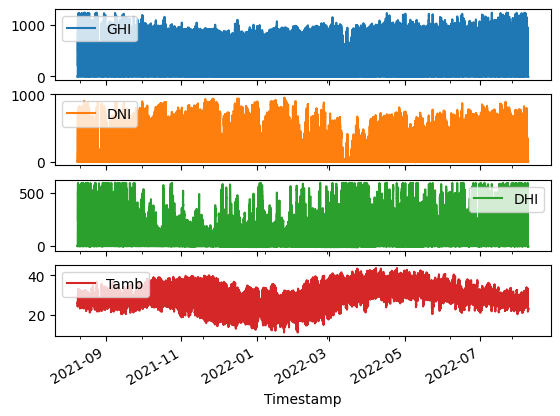

In [10]:
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])
df_clean.set_index('Timestamp')[['GHI', 'DNI', 'DHI', 'Tamb']].plot(subplots=True)


<Axes: xlabel='Cleaning'>

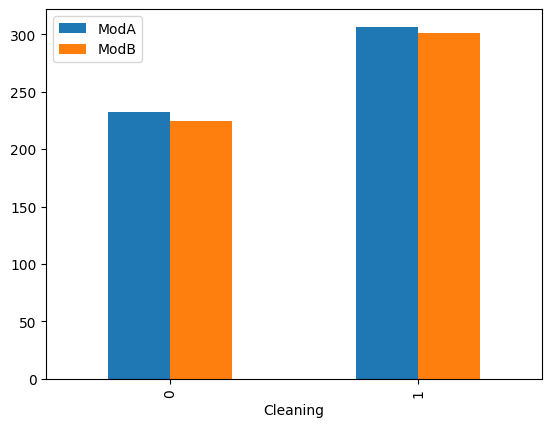

In [11]:
df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().plot(kind='bar')


<Axes: >

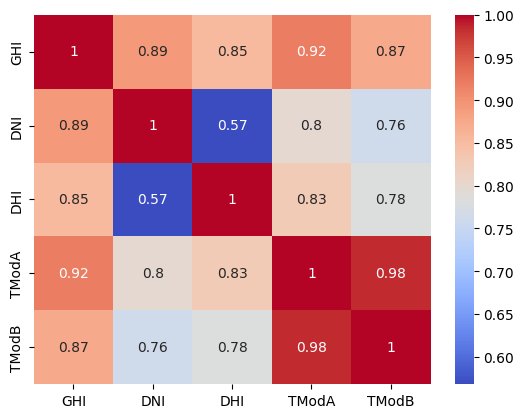

In [12]:
import seaborn as sns
sns.heatmap(df_clean[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr(), annot=True, cmap='coolwarm')


<Axes: >

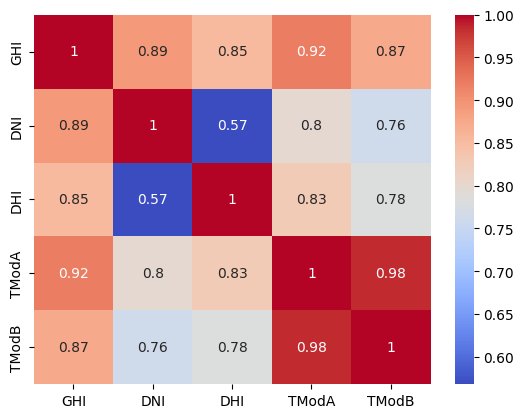

In [13]:
import seaborn as sns
sns.heatmap(df_clean[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr(), annot=True, cmap='coolwarm')


<Axes: xlabel='WS', ylabel='GHI'>

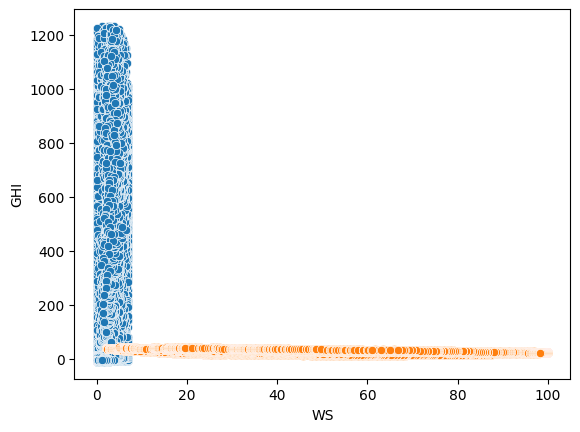

In [14]:
sns.scatterplot(x='WS', y='GHI', data=df_clean)
sns.scatterplot(x='RH', y='Tamb', data=df_clean)


<Axes: >

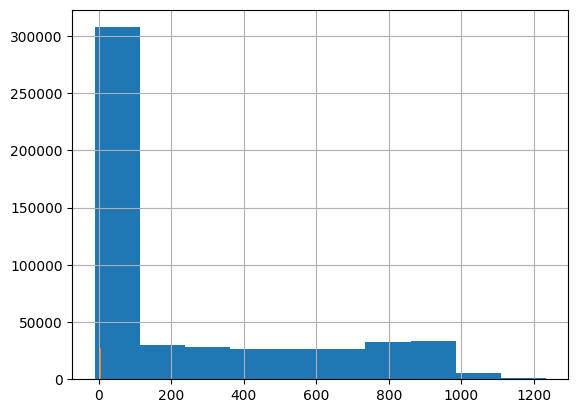

In [15]:
df_clean['GHI'].hist()
df_clean['WS'].hist()


<Axes: xlabel='RH', ylabel='Tamb'>

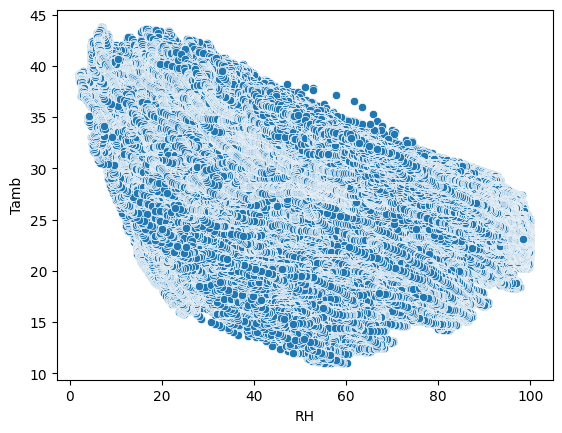

In [16]:
sns.scatterplot(x='RH', y='Tamb', data=df_clean)


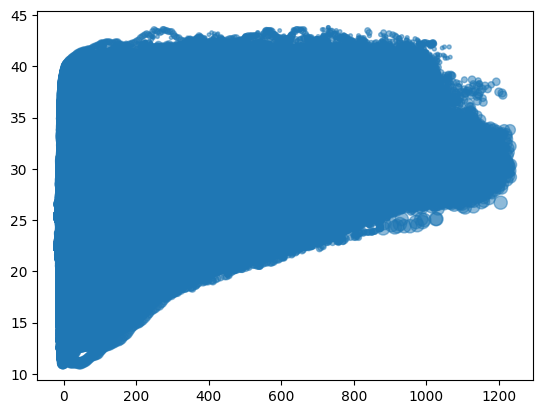

In [18]:
plt.scatter(df_clean['GHI'], df_clean['Tamb'], s=df_clean['RH'], alpha=0.5)
